### Matthew Collins
### DSC 630: Predictive Analytics
### Assignement 7.2 Create Optimal Hotel Recommendations

Online travel agencies are scrambling to meet the artificial intelligence driven personalization standard set by companies like Amazon and Netflix. In addition, the world of online travel has become a highly competitive space where brands try to capture our attention (and wallet) with recommending, comparing, matching, and sharing. For this assignment, we would like to create the optimal hotel recommendations for Expedia’s users that are searching for a hotel to book. For this assignment, you need to predict which “hotel cluster” the user is likely to book, given his (or her) search details.

In [39]:
# Import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [4]:
# import the data set "destinations.csv"

train_df = pd.read_csv('train2.csv')
dest_df = pd.read_csv('destinations.csv')

### Preliminary Analysis of a sample of the train_df

In [16]:
# evaluate the train_df shape

train_df.shape

(37670293, 24)

In [5]:
# set seed and randomly sample 10000 rows (my PC, struggles with ~38 million data points)

train_df2 = train_df.sample(n = 10000, random_state = 123)
train_df2.shape

(10000, 24)

In [6]:
# evaluate the head of the sampled dataset

train_df2.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
14927394,2013-07-25 17:24:15,2,3,66,174,35675,0.1203,44735,0,0,...,0,1,5465,3,1,1,2,50,1230,47
4018254,2014-11-02 14:49:44,2,3,66,174,31320,108.2251,794319,0,0,...,0,1,11620,1,0,2,2,50,369,83
34277084,2014-05-22 12:50:53,2,3,66,174,16292,763.1428,761732,1,0,...,0,1,23808,6,0,3,2,50,1144,93
17943701,2014-02-26 14:01:02,2,3,66,220,17605,1328.8847,696467,0,0,...,0,1,40658,5,0,1,2,50,930,48
33983050,2014-08-13 11:15:40,2,3,66,351,8978,278.0790,973058,0,0,...,0,1,8230,1,0,2,2,50,637,33


In [7]:
# understand the column data types

train_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 14927394 to 27680086
Data columns (total 24 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   date_time                  10000 non-null  object 
 1   site_name                  10000 non-null  int64  
 2   posa_continent             10000 non-null  int64  
 3   user_location_country      10000 non-null  int64  
 4   user_location_region       10000 non-null  int64  
 5   user_location_city         10000 non-null  int64  
 6   orig_destination_distance  6410 non-null   float64
 7   user_id                    10000 non-null  int64  
 8   is_mobile                  10000 non-null  int64  
 9   is_package                 10000 non-null  int64  
 10  channel                    10000 non-null  int64  
 11  srch_ci                    9982 non-null   object 
 12  srch_co                    9982 non-null   object 
 13  srch_adults_cnt            10000 non

In [8]:
# evaluate the train data set for missing values

train_df2.isna().sum()

date_time                       0
site_name                       0
posa_continent                  0
user_location_country           0
user_location_region            0
user_location_city              0
orig_destination_distance    3590
user_id                         0
is_mobile                       0
is_package                      0
channel                         0
srch_ci                        18
srch_co                        18
srch_adults_cnt                 0
srch_children_cnt               0
srch_rm_cnt                     0
srch_destination_id             0
srch_destination_type_id        0
is_booking                      0
cnt                             0
hotel_continent                 0
hotel_country                   0
hotel_market                    0
hotel_cluster                   0
dtype: int64

#### Data is missing in 3 of the 24 columns. Column orig_destination_distance has ~36% of the values missing. The other 2 are less than 1%.

In [9]:
# handle NA values, drop the orig_destination_distance column.

train_df2.drop('orig_destination_distance', inplace = True, axis = 1)
train_df2.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
14927394,2013-07-25 17:24:15,2,3,66,174,35675,44735,0,0,9,...,0,1,5465,3,1,1,2,50,1230,47
4018254,2014-11-02 14:49:44,2,3,66,174,31320,794319,0,0,3,...,0,1,11620,1,0,2,2,50,369,83
34277084,2014-05-22 12:50:53,2,3,66,174,16292,761732,1,0,1,...,0,1,23808,6,0,3,2,50,1144,93
17943701,2014-02-26 14:01:02,2,3,66,220,17605,696467,0,0,9,...,0,1,40658,5,0,1,2,50,930,48
33983050,2014-08-13 11:15:40,2,3,66,351,8978,973058,0,0,1,...,0,1,8230,1,0,2,2,50,637,33


In [10]:
# fill in the srch_ci and srch_co with most frequent values.

train_df2 = train_df2.apply(lambda x:x.fillna(x.value_counts().index[0]))
train_df2.isna().sum()

date_time                   0
site_name                   0
posa_continent              0
user_location_country       0
user_location_region        0
user_location_city          0
user_id                     0
is_mobile                   0
is_package                  0
channel                     0
srch_ci                     0
srch_co                     0
srch_adults_cnt             0
srch_children_cnt           0
srch_rm_cnt                 0
srch_destination_id         0
srch_destination_type_id    0
is_booking                  0
cnt                         0
hotel_continent             0
hotel_country               0
hotel_market                0
hotel_cluster               0
dtype: int64

<AxesSubplot:xlabel='hotel_cluster'>

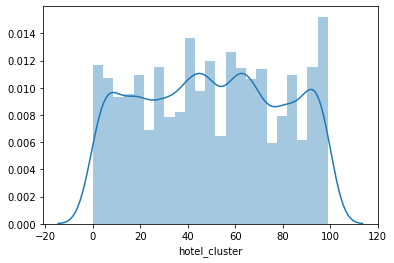

In [11]:
# plot of hotel clusters.  Help to understand the different groupings to assist with prediction of where people want to stay.

sns.distplot(train_df2['hotel_cluster'])  

#### Data appears well distributed over the clusters

In [12]:
# Extract year and month from the string column titled "date_time"

def get_year(x):
    if x is not None and type (x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
        else:
            return 2013
        pass
    
def get_month(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass

In [13]:
# transform the date_time column

train_df2['date_time_year'] = pd.Series(train_df2.date_time, index = train_df2.index)  # create new column to convert to year
train_df2['date_time_month'] = pd.Series(train_df2.date_time, index = train_df2.index) # create new column to convert to month

train_df2['date_time_year'] = train_df2['date_time_year'].apply(lambda x: get_year(x)) # call function to create year
train_df2['date_time_month'] = train_df2['date_time_month'].apply(lambda x: get_month(x)) # call function to create month

train_df2.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,date_time_year,date_time_month
14927394,2013-07-25 17:24:15,2,3,66,174,35675,44735,0,0,9,...,5465,3,1,1,2,50,1230,47,2013,7
4018254,2014-11-02 14:49:44,2,3,66,174,31320,794319,0,0,3,...,11620,1,0,2,2,50,369,83,2014,11
34277084,2014-05-22 12:50:53,2,3,66,174,16292,761732,1,0,1,...,23808,6,0,3,2,50,1144,93,2014,5
17943701,2014-02-26 14:01:02,2,3,66,220,17605,696467,0,0,9,...,40658,5,0,1,2,50,930,48,2014,2
33983050,2014-08-13 11:15:40,2,3,66,351,8978,973058,0,0,1,...,8230,1,0,2,2,50,637,33,2014,8


In [14]:
# drop the date_time column

del train_df2['date_time']

In [15]:
# show date_time column dropped

train_df2.head()

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,srch_ci,...,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster,date_time_year,date_time_month
14927394,2,3,66,174,35675,44735,0,0,9,2013-07-26,...,5465,3,1,1,2,50,1230,47,2013,7
4018254,2,3,66,174,31320,794319,0,0,3,2014-11-27,...,11620,1,0,2,2,50,369,83,2014,11
34277084,2,3,66,174,16292,761732,1,0,1,2014-05-25,...,23808,6,0,3,2,50,1144,93,2014,5
17943701,2,3,66,220,17605,696467,0,0,9,2014-02-27,...,40658,5,0,1,2,50,930,48,2014,2
33983050,2,3,66,351,8978,973058,0,0,1,2014-08-14,...,8230,1,0,2,2,50,637,33,2014,8


In [16]:
# convert the srch_ci and srch_co columns to year and month

# convert srch_ci
train_df2['srch_ci_year'] = pd.Series(train_df2.srch_ci, index = train_df2.index)
train_df2['srch_ci_month'] = pd.Series(train_df2.srch_ci, index = train_df2.index)

train_df2.srch_ci_year = train_df2.srch_ci_year.apply(lambda x: get_year(x))
train_df2.srch_ci_month = train_df2.srch_ci_month.apply(lambda x: get_month(x))

# convert srch_co
train_df2['srch_co_year'] = pd.Series(train_df2.srch_co, index = train_df2.index)
train_df2['srch_co_month'] = pd.Series(train_df2.srch_co, index = train_df2.index)

train_df2.srch_co_year = train_df2.srch_co_year.apply(lambda x: get_year(x))
train_df2.srch_co_month = train_df2.srch_co_month.apply(lambda x: get_month(x))

train_df2.head() # view the dataframe

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,srch_ci,...,hotel_continent,hotel_country,hotel_market,hotel_cluster,date_time_year,date_time_month,srch_ci_year,srch_ci_month,srch_co_year,srch_co_month
14927394,2,3,66,174,35675,44735,0,0,9,2013-07-26,...,2,50,1230,47,2013,7,2013,7,2013,7
4018254,2,3,66,174,31320,794319,0,0,3,2014-11-27,...,2,50,369,83,2014,11,2014,11,2014,11
34277084,2,3,66,174,16292,761732,1,0,1,2014-05-25,...,2,50,1144,93,2014,5,2014,5,2014,5
17943701,2,3,66,220,17605,696467,0,0,9,2014-02-27,...,2,50,930,48,2014,2,2014,2,2014,3
33983050,2,3,66,351,8978,973058,0,0,1,2014-08-14,...,2,50,637,33,2014,8,2014,8,2014,8


In [17]:
# Remove the srch_ci and srch_co columns

train_df2 = train_df2.drop(['srch_ci', 'srch_co'], axis = 1)

train_df2.head() # view dataframe to ensure eliminated

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,user_id,is_mobile,is_package,channel,srch_adults_cnt,...,hotel_continent,hotel_country,hotel_market,hotel_cluster,date_time_year,date_time_month,srch_ci_year,srch_ci_month,srch_co_year,srch_co_month
14927394,2,3,66,174,35675,44735,0,0,9,1,...,2,50,1230,47,2013,7,2013,7,2013,7
4018254,2,3,66,174,31320,794319,0,0,3,2,...,2,50,369,83,2014,11,2014,11,2014,11
34277084,2,3,66,174,16292,761732,1,0,1,2,...,2,50,1144,93,2014,5,2014,5,2014,5
17943701,2,3,66,220,17605,696467,0,0,9,2,...,2,50,930,48,2014,2,2014,2,2014,3
33983050,2,3,66,351,8978,973058,0,0,1,2,...,2,50,637,33,2014,8,2014,8,2014,8


In [18]:
# check correlation of the variables against the hotel cluster

train_df2.corr()['hotel_cluster'].sort_values()

is_booking                 -0.031622
srch_destination_type_id   -0.029195
site_name                  -0.026988
hotel_continent            -0.024912
hotel_country              -0.015802
date_time_year             -0.011412
srch_destination_id        -0.011021
srch_ci_year               -0.006233
srch_co_month              -0.006055
channel                    -0.005971
srch_co_year               -0.005263
srch_ci_month              -0.004250
date_time_month            -0.003735
user_location_city          0.004959
cnt                         0.007512
user_location_country       0.008558
user_id                     0.008629
srch_rm_cnt                 0.009404
user_location_region        0.009888
srch_children_cnt           0.027127
srch_adults_cnt             0.027252
posa_continent              0.032443
is_package                  0.034700
is_mobile                   0.040845
hotel_market                0.050569
hotel_cluster               1.000000
Name: hotel_cluster, dtype: float64

#### None of the columns appear to correlate with the hotel clusters

<AxesSubplot:>

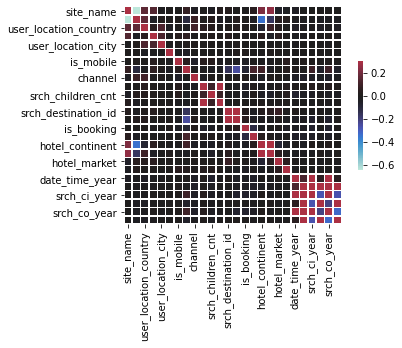

In [19]:
# create a correlation heat map

corr_map = train_df2.corr()
sns.heatmap(corr_map, vmax = 0.3, center = 0, 
            square = True, linewidth = 0.5, cbar_kws = {'shrink': 0.5})

#### Not tremendous correlation between variables, except for a few combinations.

#### Search destinations will group by hotels that are located in certain areas.  Different countries, have different family of hotels.  Will group to evaluate by country and market.

In [20]:
# groupby search destination, hotel country, hotel market, and hotel cluster

group_pieces = [train_df2.groupby(['srch_destination_id','hotel_country','hotel_market','hotel_cluster'])['is_booking'].agg(['sum','count'])]
agg = pd.concat(group_pieces).groupby(level=[0,1,2,3]).sum()
agg.dropna(inplace=True)
agg.head()

sum  count
srch_destination_id hotel_country hotel_market hotel_cluster            
21                  77            1454         29               0      1
                                               82               0      1
24                  50            606          91               1      1
27                  60            1554         30               0      1
33                  194           1526         29               0      1

In [21]:
# cluster the information

agg['sum_and_cnt'] = 0.85*agg['sum'] + 0.15*agg['count']
agg = agg.groupby(level=[0,1,2]).apply(lambda x: x.astype(float)/x.sum())
agg.reset_index(inplace=True)
agg.head()

,srch_destination_id,hotel_country,hotel_market,hotel_cluster,sum,count,sum_and_cnt
0,21,77,1454,29,NaN,0.500000,0.500000
1,21,77,1454,82,NaN,0.500000,0.500000
2,24,50,606,91,1.0,1.000000,1.000000
3,27,60,1554,30,NaN,1.000000,1.000000
4,33,194,1526,29,NaN,0.333333,0.333333


In [22]:
# create a pivot of teh clustering

agg_pivot = agg.pivot_table(index=['srch_destination_id','hotel_country','hotel_market'], 
                            columns='hotel_cluster', values='sum_and_cnt').reset_index()
agg_pivot.head()  # view the first 5 rows

hotel_cluster,srch_destination_id,hotel_country,hotel_market,0,1,2,3,4,5,6,...,90,91,92,93,94,95,96,97,98,99
0,21,77,1454,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,24,50,606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,27,60,1554,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,33,194,1526,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,40,8,164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Preliminary Analysis of the dest_df

In [23]:
# evaluate the data set shape

dest_df.shape

(62106, 150)

In [24]:
# evalutate the dataframe for missing values

dest_df.isna().sum()         

srch_destination_id    0
d1                     0
d2                     0
d3                     0
d4                     0
                      ..
d145                   0
d146                   0
d147                   0
d148                   0
d149                   0
Length: 150, dtype: int64

#### No values are missing from the dataset.

In [25]:
# understand the column data types

dest_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62106 entries, 0 to 62105
Columns: 150 entries, srch_destination_id to d149
dtypes: float64(149), int64(1)
memory usage: 71.1 MB


In [26]:
# Scale the data 

scaler = StandardScaler()
scaled = scaler.fit_transform(dest_df)


In [27]:
# Reduce the dimensionality of the dest_df.  Note 6 components selected, if scree or variance not evident will change

pca = PCA(n_components = 6)
principal_components = pca.fit_transform(scaled)

In [28]:
# create and evaluate principal_component as df

principal_df = pd.DataFrame(data = principal_components, columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6'])
principal_df.head()

,pc1,pc2,pc3,pc4,pc5,pc6
0,-1.194769,1.380711,-0.614037,-0.357841,0.889823,1.268021
1,-6.620522,-0.288225,0.707177,-0.832915,-0.234852,0.757601
2,1.138289,0.255230,1.150624,3.282166,-3.021600,0.192543
3,-7.373590,-0.431818,0.055330,-0.557086,-0.104685,0.186256
4,-3.743202,-0.624888,0.538233,0.619014,-0.062017,-0.679423


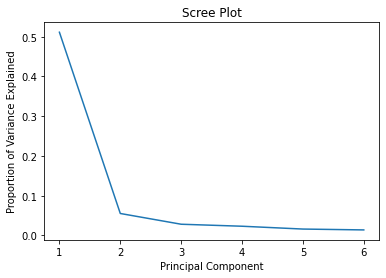

In [29]:
# create scree plot for visualization

PC_values = np.arange(pca.n_components) + 1
plt.plot(PC_values, pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

#### The scree plot would suggest the optimal number of components should be 3.   I will reduce  for the evaluation.

In [30]:
# reduce to 3 principal components

pca = PCA(n_components = 3)
principal_components = pca.fit_transform(scaled)
principal_df = pd.DataFrame(data = principal_components, columns = ['pc1', 'pc2', 'pc3'])
principal_df.head()

,pc1,pc2,pc3
0,-1.194769,1.380711,-0.614104
1,-6.620522,-0.288225,0.707156
2,1.138289,0.255229,1.150555
3,-7.373590,-0.431818,0.055297
4,-3.743202,-0.624888,0.538134


In [31]:
# add back in the serach destination id

principal_df['srch_destination_id'] = dest_df['srch_destination_id']
principal_df.head()

,pc1,pc2,pc3,srch_destination_id
0,-1.194769,1.380711,-0.614104,0
1,-6.620522,-0.288225,0.707156,1
2,1.138289,0.255229,1.150555,2
3,-7.373590,-0.431818,0.055297,3
4,-3.743202,-0.624888,0.538134,4


### Merge the destination (principal_df) with train_df2 and agg_pivot tables

In [32]:
# create a new dataframe by merging the output of destinations (aka pca analysis) with training (aka train_df2)

new_df = pd.merge(train_df2, principal_df, how='left', on='srch_destination_id')
new_df = pd.merge(train_df2, agg_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market'])
new_df.fillna(0, inplace=True)
new_df.shape   # provide overview of the dataframe shape after merging the two sets

(10000, 126)

In [33]:
# only interested if booking happened

new_df = new_df.loc[new_df['is_booking'] == 1]

In [34]:
# set the x and y features

X = new_df.drop(['user_id', 'hotel_cluster', 'is_booking'], axis = 1)
y = new_df['hotel_cluster']

In [36]:
# split the data 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
print("{} rows in test set vs. {} in training set. {} Features.".format(X_test.shape[0], X_train.shape[0], X_test.shape[1]))

238 rows in test set vs. 554 in training set. 123 Features.


In [67]:
# Naive Bayes assessment

clf = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))

np.mean(cross_val_score(clf, X, y, cv=10))

C:\Users\quefi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


0.17425632911392402

In [69]:
# K-Nearest Neighbor Classifier Assessment

clf = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=5))
np.mean(cross_val_score(clf, X, y, cv=10, scoring='accuracy'))

C:\Users\quefi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


0.5795411392405063

In [77]:
# Random Forest Assessment

clf = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators = 273,max_depth = 20,random_state = 0))
np.mean(cross_val_score(clf, X, y, cv = 10))

C:\Users\quefi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


0.5543196202531645

In [74]:
# Logistic Regression Assessment

clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(multi_class = 'ovr'))
np.mean(cross_val_score(clf, X, y, cv = 10))

C:\Users\quefi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


0.5947310126582279

In [76]:
# SVM Assessment

clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(decision_function_shape = 'ovo'))
np.mean(cross_val_score(clf, X, y, cv = 10))

C:\Users\quefi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


0.5796518987341772

### Outcome Analysis

### Accuracies
#### Naive Bayes = ~17%
#### K-NN = ~58%
#### Random Forest = ~55%
#### Logistic Regression = ~59%
#### SVM = ~58%

#### Overall Naive Bayes had the lowest performance (it was tough to see why this performed so much worse compared to other models), the other models were slightly better than a flip of the coin, with Logestic Regression haveing the highest percent.  

### Recommendations

At this point, the models are not that strong.  I would look to perform some additional feature engineering.  This may build upon the current models in support of better predictions.   

#### Works Consulted:
https://towardsdatascience.com/a-machine-learning-approach-building-a-hotel-recommendation-engine-6812bfd53f50

https://github.com/danieltlo/Expedia-Hotel-Recommendations

https://github.com/ycheng30/Expedia-Hotel-Recommendation-Kaggle